# Analisis Big Data Keterlambatan Penerbangan
Domain: Transportasi Udara

Keputusan Bisnis: Identifikasi faktor dominan penyebab delay penerbangan

---

Nama : Brilly Jalu Kumara Biseka

NIM  : 25917018


In [63]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, to_date, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Inisiasi Spark Session
spark = SparkSession.builder \
    .appName("Airline_Analysis") \
    .getOrCreate()

In [64]:
# Memuat dataset (Pastikan file csv sudah diupload)
df_delay = spark.read.csv("Dataset/Airline_Delay_Cause.csv", header=True, inferSchema=True)
df_routes = spark.read.csv("Dataset/US Airline Flight Routes and Fares 1993-2024.csv", header=True, inferSchema=True)

df_delay.printSchema()
df_routes.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- carrier: string (nullable = true)
 |-- carrier_name: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- airport_name: string (nullable = true)
 |-- arr_flights: integer (nullable = true)
 |-- arr_del15: integer (nullable = true)
 |-- carrier_ct: double (nullable = true)
 |-- weather_ct: double (nullable = true)
 |-- nas_ct: double (nullable = true)
 |-- security_ct: double (nullable = true)
 |-- late_aircraft_ct: double (nullable = true)
 |-- arr_cancelled: integer (nullable = true)
 |-- arr_diverted: integer (nullable = true)
 |-- arr_delay: integer (nullable = true)
 |-- carrier_delay: integer (nullable = true)
 |-- weather_delay: integer (nullable = true)
 |-- nas_delay: integer (nullable = true)
 |-- security_delay: integer (nullable = true)
 |-- late_aircraft_delay: integer (nullable = true)

root
 |-- tbl: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- quarter

In [65]:
from pyspark.sql.functions import avg, sum

# Mengelompokkan data berdasarkan bandara (airport) dan tahun (year)
# Tujuannya: 1 baris data merepresentasikan 1 bandara pada 1 tahun
df_delay_agg = df_delay.groupBy("airport", "year").agg(
    # Menghitung rata-rata keterlambatan kedatangan
    avg("arr_delay").alias("avg_arr_delay"),

    # Menghitung total delay yang disebabkan oleh maskapai
    sum("carrier_delay").alias("total_carrier_delay"),

    # Menghitung total delay akibat kondisi cuaca
    sum("weather_delay").alias("total_weather_delay"),

    # Menghitung total delay akibat sistem penerbangan nasional (NAS)
    sum("nas_delay").alias("total_nas_delay"),

    # Menghitung total delay karena pesawat datang terlambat dari penerbangan sebelumnya
    sum("late_aircraft_delay").alias("total_late_aircraft_delay")
)

df_delay_agg.show(5)


+-------+----+------------------+-------------------+-------------------+---------------+-------------------------+
|airport|year|     avg_arr_delay|total_carrier_delay|total_weather_delay|total_nas_delay|total_late_aircraft_delay|
+-------+----+------------------+-------------------+-------------------+---------------+-------------------------+
|    LFT|2022| 924.8421052631579|               5897|               1783|           2678|                     7214|
|    LIH|2022|1393.9333333333334|              23404|                552|           4800|                    12847|
|    ALO|2022|             301.0|                613|                169|            241|                      482|
|    CRP|2021|1106.6153846153845|              14107|               6005|           4471|                    18510|
|    SJT|2021|  849.304347826087|               7602|               3447|           1868|                     6617|
+-------+----+------------------+-------------------+-------------------

In [66]:
# Mengelompokkan data rute penerbangan berdasarkan bandara asal (airport_1) dan tahun
# Tujuannya: mendapatkan statistik bisnis per bandara per tahun
df_fare_airport1 = df_routes.groupBy("airport_1", "Year").agg(
    # Menghitung rata-rata harga tiket (fare) dari seluruh rute yang berangkat
    avg("fare").alias("avg_fare"),
    # Menghitung total jumlah penumpang yang berangkat
    sum("passengers").alias("total_passengers")
# Mengganti nama kolom airport_1 menjadi airport
# Agar konsisten dengan dataset delay dan memudahkan proses join
).withColumnRenamed("airport_1", "airport")


In [67]:
# Mengelompokkan data rute penerbangan berdasarkan bandara asal (airport_2) dan tahun
# Tujuannya: mendapatkan statistik bisnis per bandara per tahun
df_fare_airport2 = df_routes.groupBy("airport_2", "Year").agg(
    # Menghitung rata-rata harga tiket (fare) dari seluruh rute yang berangkat
    avg("fare").alias("avg_fare"),
    # Menghitung total jumlah penumpang yang berangkat
    sum("passengers").alias("total_passengers")
# Mengganti nama kolom airport_2 menjadi airport
# Agar konsisten dengan dataset delay dan memudahkan proses join 
).withColumnRenamed("airport_2", "airport")


In [68]:
# Menggabungkan data statistik bandara asal (airport_1)
# dan bandara tujuan (airport_2) menjadi satu DataFrame
# Tujuannya: mendapatkan total aktivitas bisnis bandara
# tanpa membedakan apakah bandara tersebut sebagai asal atau tujuan
df_fare_airport = df_fare_airport1.unionByName(df_fare_airport2)


In [69]:
# Melakukan agregasi ulang setelah data bandara asal dan tujuan digabung
# Grouping berdasarkan:
# - airport : kode bandara
# - Year    : tahun pengamatan
# Tujuan:
# - Menghitung rata-rata harga tiket (avg_fare) per bandara per tahun
# - Menghitung total penumpang (total_passengers) per bandara per tahun
# Ini menghasilkan representasi aktivitas bisnis tahunan tiap bandara
df_fare_airport_final = df_fare_airport.groupBy("airport", "Year").agg(
    avg("avg_fare").alias("avg_fare"),
    sum("total_passengers").alias("total_passengers")
)


In [70]:
# Menggabungkan (join) data keterlambatan penerbangan dengan data bisnis bandara
# Join dilakukan berdasarkan:
# - airport : kode bandara yang sama
# - year    : tahun yang sama
# Jenis join:
# - left join → semua data delay dipertahankan,
#   meskipun data fare / penumpang tidak tersedia
# Tujuan:
# - Menghasilkan dataset gabungan antara performa operasional (delay)
#   dan aspek bisnis (harga tiket & jumlah penumpang)
df_final = df_delay_agg.join(
    df_fare_airport_final,
    (df_delay_agg.airport == df_fare_airport_final.airport) &
    (df_delay_agg.year == df_fare_airport_final.Year),
    how="left"
)


In [71]:
from pyspark.sql.functions import avg, sum

# Melakukan agregasi data delay penerbangan
# Data dikelompokkan berdasarkan:
# - airport : kode bandara
# - year    : tahun penerbangan
# Tujuan agregasi:
# - Menghitung rata-rata keterlambatan kedatangan (avg_arr_delay)
# - Menjumlahkan masing-masing penyebab delay untuk melihat kontribusinya per tahun per bandara
df_delay_agg = df_delay.groupBy("airport", "year").agg(
    avg("arr_delay").alias("avg_arr_delay"),          # Rata-rata delay kedatangan
    sum("carrier_delay").alias("carrier_delay"),      # Total delay akibat maskapai
    sum("weather_delay").alias("weather_delay"),      # Total delay akibat cuaca
    sum("nas_delay").alias("nas_delay"),              # Total delay akibat sistem navigasi udara (NAS)
    sum("late_aircraft_delay").alias("late_aircraft_delay")  # Total delay karena pesawat datang terlambat
)

df_delay_agg.show(5)


+-------+----+------------------+-------------+-------------+---------+-------------------+
|airport|year|     avg_arr_delay|carrier_delay|weather_delay|nas_delay|late_aircraft_delay|
+-------+----+------------------+-------------+-------------+---------+-------------------+
|    LFT|2022| 924.8421052631579|         5897|         1783|     2678|               7214|
|    LIH|2022|1393.9333333333334|        23404|          552|     4800|              12847|
|    ALO|2022|             301.0|          613|          169|      241|                482|
|    CRP|2021|1106.6153846153845|        14107|         6005|     4471|              18510|
|    SJT|2021|  849.304347826087|         7602|         3447|     1868|               6617|
+-------+----+------------------+-------------+-------------+---------+-------------------+
only showing top 5 rows



In [72]:
# Menggabungkan (join) data delay dengan data bisnis penerbangan (fare & penumpang)
# Jenis join: LEFT JOIN
# Artinya:
# - Semua data dari df_delay_agg (delay) akan dipertahankan
# - Data fare dan penumpang akan ditambahkan jika pasangan airport & year ditemukan
# Kondisi join:
# - airport pada data delay sama dengan airport pada data fare
# - year pada data delay sama dengan Year pada data fare
# Alasan LEFT JOIN:
# - Tidak semua bandara/tahun memiliki data fare & penumpang
# - Tetap ingin mempertahankan informasi delay untuk analisis
df_final = df_delay_agg.join(
    df_fare_airport_final,
    (df_delay_agg.airport == df_fare_airport_final.airport) &
    (df_delay_agg.year == df_fare_airport_final.Year),
    how="left"
)


In [73]:
# Menampilkan struktur (schema) DataFrame hasil join
# Digunakan untuk:
# - Mengecek nama kolom
# - Mengecek tipe data tiap kolom (int, float, string, dll)
# - Memastikan hasil join berhasil dan kolom yang diharapkan ada
df_final.printSchema()

# Menampilkan 5 baris pertama dari DataFrame final
# Digunakan untuk:
# - Validasi isi data secara cepat
# - Melihat apakah nilai hasil agregasi dan join masuk akal
# - Mengecek apakah ada nilai NULL setelah LEFT JOIN
df_final.show(5)


root
 |-- airport: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- avg_arr_delay: double (nullable = true)
 |-- carrier_delay: long (nullable = true)
 |-- weather_delay: long (nullable = true)
 |-- nas_delay: long (nullable = true)
 |-- late_aircraft_delay: long (nullable = true)
 |-- airport: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- avg_fare: double (nullable = true)
 |-- total_passengers: long (nullable = true)

+-------+----+------------------+-------------+-------------+---------+-------------------+-------+----+--------+----------------+
|airport|year|     avg_arr_delay|carrier_delay|weather_delay|nas_delay|late_aircraft_delay|airport|Year|avg_fare|total_passengers|
+-------+----+------------------+-------------+-------------+---------+-------------------+-------+----+--------+----------------+
|    LFT|2022| 924.8421052631579|         5897|         1783|     2678|               7214|   null|null|    null|            null|
|    LIH|2022|

In [74]:
# Memilih kolom-kolom yang benar-benar dibutuhkan untuk analisis akhir
# Tujuan:
# - Merapikan dataset (feature selection)
# - Menghindari kolom duplikat hasil join
# - Menyamakan struktur dataset agar siap diekspor & dianalisis
df_final_clean = df_final.select(
    # identitas airport
    df_delay_agg.airport.alias("airport"),
    df_delay_agg.year.alias("year"),
    "avg_arr_delay",
    "carrier_delay",
    "weather_delay",
    "nas_delay",
    "late_aircraft_delay",

    # Informasi bisnis penerbangan
    # (tidak semua airport-tahun punya data → bisa bernilai NULL)
    "avg_fare",
    "total_passengers"
)


In [75]:
from pyspark.sql.functions import col

# Menambahkan kolom total_delay
# total_delay = penjumlahan seluruh komponen penyebab keterlambatan
# Kolom ini akan menjadi:
# - target utama analisis korelasi
# - metrik ringkas untuk dashboard (lebih mudah dipahami daripada banyak komponen)
df_final_clean = df_final_clean.withColumn(
    "total_delay",
    col("carrier_delay") +          # Delay akibat maskapai
    col("weather_delay") +          # Delay akibat cuaca
    col("nas_delay") +              # Delay akibat sistem NAS (air traffic control, dll)
    col("late_aircraft_delay")      # Delay akibat pesawat datang terlambat
)


In [76]:
# Mengonversi Spark DataFrame menjadi Pandas DataFrame
# Langkah ini dilakukan karena:
# 1. Dataset final sudah relatif kecil (± ribuan baris)
# 2. Analisis lanjutan (korelasi, visualisasi, dashboard) akan lebih mudah di Pandas / Seaborn / Streamlit
df_final_clean.toPandas().to_csv(
    "airport_delay_business_v2.csv",
    index=False
)



---
# Proses Analisis

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (8,5)


In [78]:
df = pd.read_csv(
    "airport_delay_business_v2.csv"
)

df.head()


,airport,year,avg_arr_delay,carrier_delay,weather_delay,nas_delay,late_aircraft_delay,avg_fare,total_passengers,total_delay
0,LFT,2022,924.842105,5897.0,1783.0,2678.0,7214.0,NaN,NaN,17572.0
1,LIH,2022,1393.933333,23404.0,552.0,4800.0,12847.0,NaN,NaN,41603.0
2,ALO,2022,301.000000,613.0,169.0,241.0,482.0,NaN,NaN,1505.0
3,CRP,2021,1106.615385,14107.0,6005.0,4471.0,18510.0,191.87,252.0,43093.0
4,SJT,2021,849.304348,7602.0,3447.0,1868.0,6617.0,NaN,NaN,19534.0


In [79]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6412 entries, 0 to 6411
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   airport              6411 non-null   object 
 1   year                 6412 non-null   int64  
 2   avg_arr_delay        6402 non-null   float64
 3   carrier_delay        6402 non-null   float64
 4   weather_delay        6402 non-null   float64
 5   nas_delay            6402 non-null   float64
 6   late_aircraft_delay  6402 non-null   float64
 7   avg_fare             2765 non-null   float64
 8   total_passengers     2765 non-null   float64
 9   total_delay          6402 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 501.1+ KB


In [80]:
# Menghapus baris data yang memiliki nilai kosong (NaN)
# khusus pada kolom:
# - avg_fare (rata-rata harga tiket)
# - total_passengers (total penumpang)
#
# Alasan:
# - Dua kolom ini penting untuk analisis bisnis
# - Korelasi dan visualisasi akan bias / error jika ada NaN
# - Kita memilih hanya data yang benar-benar lengkap untuk analisis
df = df.dropna(subset=["avg_fare", "total_passengers"])


In [81]:
df.describe()


,year,avg_arr_delay,carrier_delay,weather_delay,nas_delay,late_aircraft_delay,avg_fare,total_passengers,total_delay
count,2765.000000,2765.000000,2.765000e+03,2765.000000,2.765000e+03,2.765000e+03,2765.000000,2765.000000,2.765000e+03
mean,2012.928752,4113.912127,1.348764e+05,22970.193852,1.213835e+05,1.725011e+05,217.087753,37796.256420,4.517312e+05
std,5.756044,5463.023067,2.015558e+05,39360.014732,3.060057e+05,2.736828e+05,49.746867,58986.717577,7.728719e+05
min,2003.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,72.150000,0.000000,0.000000e+00
25%,2008.000000,1283.154762,2.434500e+04,4024.000000,9.958000e+03,2.474100e+04,187.637500,1579.000000,6.503300e+04
50%,2013.000000,2073.457143,5.702400e+04,9462.000000,2.567000e+04,6.424600e+04,214.863889,9914.000000,1.586600e+05
75%,2018.000000,4239.148148,1.543650e+05,22770.000000,8.411600e+04,2.051390e+05,243.322220,45655.000000,4.679080e+05
max,2022.000000,50843.409722,1.906310e+06,454318.000000,3.770316e+06,2.588193e+06,508.216667,401965.000000,7.629339e+06


In [82]:
# Menghitung korelasi antar kolom numerik dalam DataFrame df
corr = df.corr(numeric_only=True)
corr


,year,avg_arr_delay,carrier_delay,weather_delay,nas_delay,late_aircraft_delay,avg_fare,total_passengers,total_delay
year,1.000000,-0.019434,-0.028935,-0.102283,-0.116338,-0.077135,0.226759,-0.037462,-0.086131
avg_arr_delay,-0.019434,1.000000,0.884087,0.833110,0.846183,0.901064,0.017556,0.799208,0.927096
carrier_delay,-0.028935,0.884087,1.000000,0.908172,0.754040,0.947223,0.007241,0.776085,0.941010
weather_delay,-0.102283,0.833110,0.908172,1.000000,0.783402,0.860675,-0.021316,0.667077,0.902717
nas_delay,-0.116338,0.846183,0.754040,0.783402,1.000000,0.819571,-0.010989,0.685997,0.922694
late_aircraft_delay,-0.077135,0.901064,0.947223,0.860675,0.819571,1.000000,-0.007742,0.805348,0.969463
avg_fare,0.226759,0.017556,0.007241,-0.021316,-0.010989,-0.007742,1.000000,0.002518,-0.006290
total_passengers,-0.037462,0.799208,0.776085,0.667077,0.685997,0.805348,0.002518,1.000000,0.793158
total_delay,-0.086131,0.927096,0.941010,0.902717,0.922694,0.969463,-0.006290,0.793158,1.000000


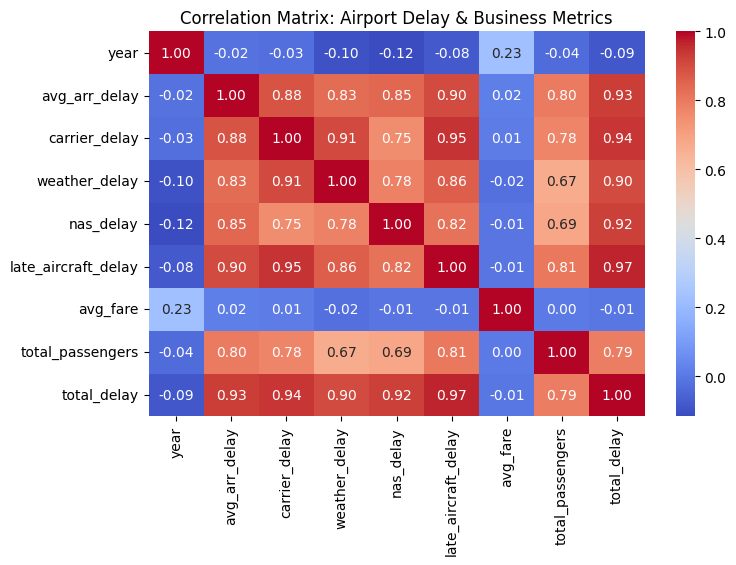

In [83]:
# Membuat heatmap visualisasi matriks korelasi menggunakan seaborn
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Matrix: Airport Delay & Business Metrics")
plt.show()


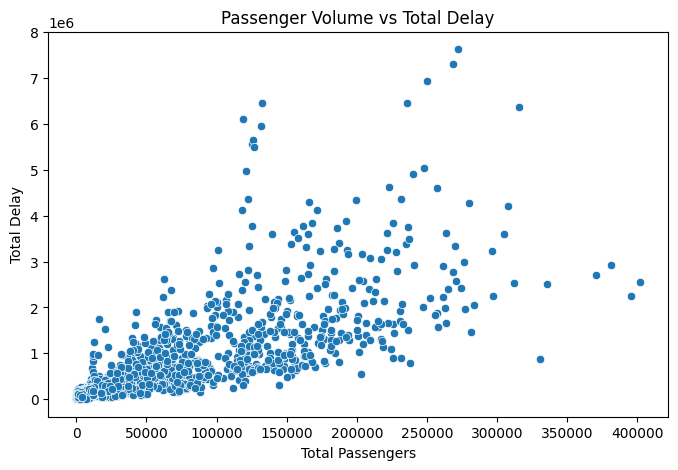

In [84]:
# Membuat scatter plot untuk melihat hubungan antara total penumpang dan total delay
sns.scatterplot(
    data=df,
    x="total_passengers",
    y="total_delay"
)
plt.title("Passenger Volume vs Total Delay")
plt.xlabel("Total Passengers")
plt.ylabel("Total Delay")
plt.show()


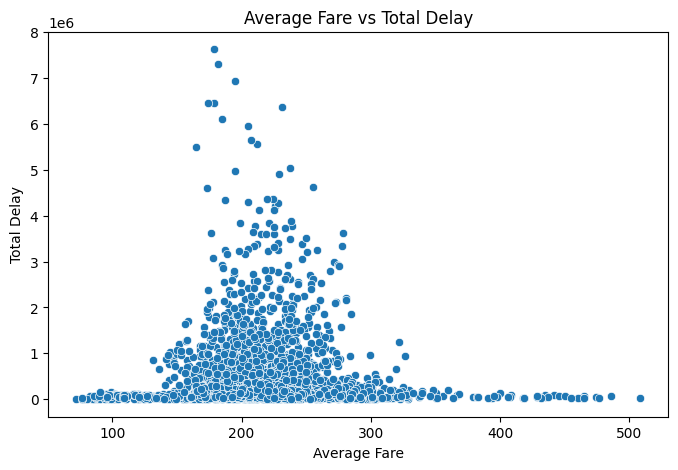

In [85]:
# Membuat scatter plot untuk melihat hubungan antara total penumpang dan total delay
sns.scatterplot(
    data=df,
    x="avg_fare",
    y="total_delay"
)
plt.title("Average Fare vs Total Delay")
plt.xlabel("Average Fare")
plt.ylabel("Total Delay")
plt.show()


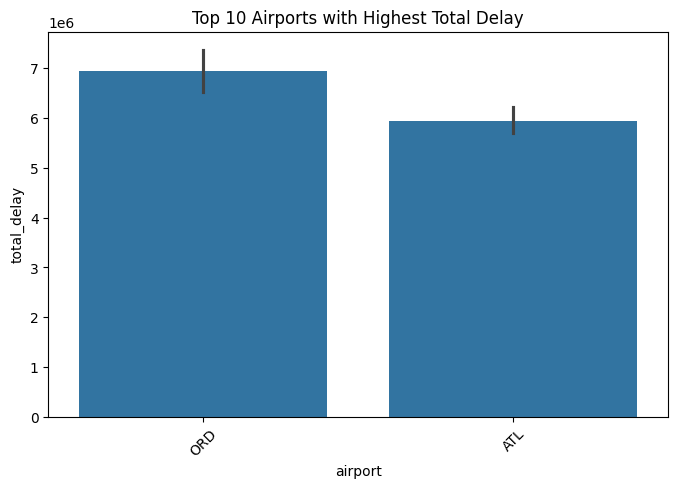

In [86]:
# Mengurutkan DataFrame berdasarkan kolom 'total_delay' secara menurun dan mengambil 10 teratas
top_delay = df.sort_values(
    by="total_delay",
    ascending=False
).head(10)

sns.barplot(
    data=top_delay,
    x="airport",
    y="total_delay"
)
plt.title("Top 10 Airports with Highest Total Delay")
plt.xticks(rotation=45)
plt.show()


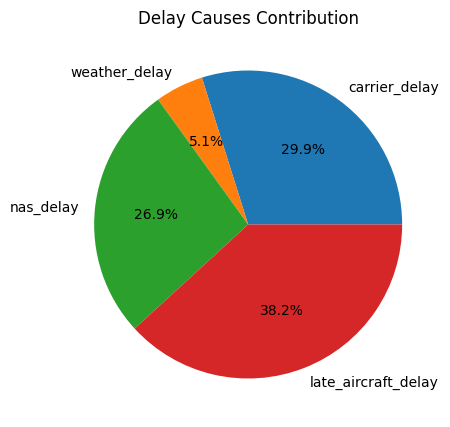

In [87]:
delay_causes = [
    "carrier_delay",
    "weather_delay",
    "nas_delay",
    "late_aircraft_delay"
]

cause_sum = df[delay_causes].sum()
# Membuat pie chart untuk visualisasi kontribusi masing-masing penyebab delay
cause_sum.plot(
    kind="pie",
    autopct="%1.1f%%",
    title="Delay Causes Contribution"
)
plt.ylabel("")
plt.show()


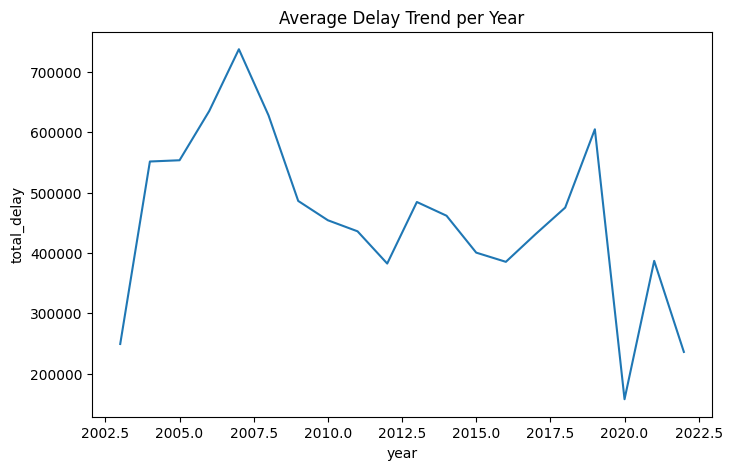

In [88]:
# Mengelompokkan data berdasarkan kolom 'year' dan menghitung rata-rata 'total_delay' untuk tiap tahun
yearly_delay = df.groupby("year")["total_delay"].mean().reset_index()
# Membuat plot garis menggunakan seaborn untuk menampilkan tren rata-rata delay per tahun
sns.lineplot(
    data=yearly_delay,
    x="year",
    y="total_delay"
)
plt.title("Average Delay Trend per Year")
plt.show()


In [96]:
# ==========================================
# BAGIAN: ANALISIS MACHINE LEARNING (PREDIKSI & AKURASI)
# ==========================================

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col

# 1. PERSIAPAN DATA (PREPROCESSING)
# ----------------------------------
# Kita akan memprediksi apakah suatu bandara akan mengalami "High Delay" (rata-rata > 15 menit)
# berdasarkan faktor bisnis: 'avg_fare' (harga tiket) dan 'total_passengers' (jumlah penumpang).

# Buat salinan data dan hapus baris yang memiliki nilai kosong pada kolom fitur
data_ml = df_final_clean.dropna(subset=["avg_fare", "total_passengers", "avg_arr_delay"])

# Membuat Label Klasifikasi:
# Nilai 1 = High Delay (Rata-rata delay > 1440 menit (24 jam))
# Nilai 0 = Normal (Rata-rata delay <= 1440 menit (24 jam))
data_ml = data_ml.withColumn("label", when(col("avg_arr_delay") > 1440, 1).otherwise(0))

# Menggabungkan kolom fitur (input) menjadi satu kolom vektor bernama 'features'
assembler = VectorAssembler(
    inputCols=["avg_fare", "total_passengers"],
    outputCol="features"
)
data_ml_final = assembler.transform(data_ml)

# 2. SPLITTING DATA
# -----------------
# Membagi data menjadi 80% Training dan 20% Testing
train_data, test_data = data_ml_final.randomSplit([0.8, 0.2], seed=42)

# 3. TRAINING MODEL
# -----------------
# Inisialisasi model Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Melatih model dengan data training
lr_model = lr.fit(train_data)

# 4. EVALUASI & AKURASI
# ---------------------
# Melakukan prediksi pada data testing
predictions = lr_model.transform(test_data)

# Menyiapkan evaluator untuk menghitung akurasi
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)

# Menghitung akurasi
accuracy = evaluator.evaluate(predictions)

# MENAMPILKAN HASIL
print("="*40)
print(f"HASIL EVALUASI MODEL LOGISTIC REGRESSION")
print("="*40)
print(f"Akurasi Model: {accuracy:.2%}")
print("-" * 40)
print("Confusion Matrix (Label vs Prediksi):")
predictions.groupBy("label", "prediction").count().show()

print("-" * 40)
print("INTERPRETASI KOEFISIEN (PENGARUH FITUR):")
# Koefisien positif (+) artinya semakin tinggi nilai fitur, semakin besar peluang delay.
# Koefisien negatif (-) artinya semakin tinggi nilai fitur, semakin kecil peluang delay.
print(f"1. Avg Fare (Harga Tiket)    : {lr_model.coefficients[0]:.5f}")
print(f"2. Total Passengers (Volume) : {lr_model.coefficients[1]:.5f}")
print("="*40)

HASIL EVALUASI MODEL LOGISTIC REGRESSION
Akurasi Model: 78.06%
----------------------------------------
Confusion Matrix (Label vs Prediksi):
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   64|
|    0|       0.0|  119|
|    1|       1.0|  276|
|    0|       1.0|   47|
+-----+----------+-----+

----------------------------------------
INTERPRETASI KOEFISIEN (PENGARUH FITUR):
1. Avg Fare (Harga Tiket)    : 0.00011
2. Total Passengers (Volume) : 0.00017
